In [1]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import tensorflow as tf
import csv
import os
import random
import math
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
x_path = '/Users/mac/code/custom-cnn/train_images/X_train_7.csv'
y_path = '/Users/mac/code/custom-cnn/train_labels/train_labels_7.csv'
img_shape = 28
CLASSNAMES = {
    '0' : 'buildings',
    '1' : 'barren-land',
    '2' : 'water',
    '3' : 'grassland', 
    '4' : 'roads',
    '5' : 'trees', 
}

# este metodo tiene como proposito facilitar la visualizacion de las siguientes imagenes
def process_data_for_visualization(train_path, label_path, img_shape, n_rows):
    # Pre-processing data. Returns numpy arrays
    img_df = pd.read_csv(train_path, nrows=n_rows, header=None) 
    labels_df = pd.read_csv(label_path, nrows=n_rows, header=None)
    np_x = img_df.values.astype(np.uint8)
    np_x = np_x.reshape(-1, img_shape, img_shape, 4)
    np_x = np_x[:, :, :, :3]

    np_y = labels_df.values.astype(np.uint8)
    y = np.argmax(np_y, axis=1)

    return np_x, y

# est emetodo tiene como proposito el procesamiento de los datos para el modelo
def process_data(img_df, labels_df, img_shape):
    # Pre-processing data. Returns numpy arrays
    np_x = img_df.values.astype(np.uint8)
    np_x = np_x.reshape(-1, img_shape, img_shape, 4)
    np_x = np_x[:, :, :, :3]

    np_y = labels_df.values.astype(np.uint8)

    return np_x, np_y

In [3]:
images, labels = process_data_for_visualization(x_path, y_path, img_shape, 30)

In [4]:
print(images.shape, labels.shape)

(30, 28, 28, 3) (30,)


#### Ploteamos 30 muestras, y guardamos un ejemplo de cada una de las clases

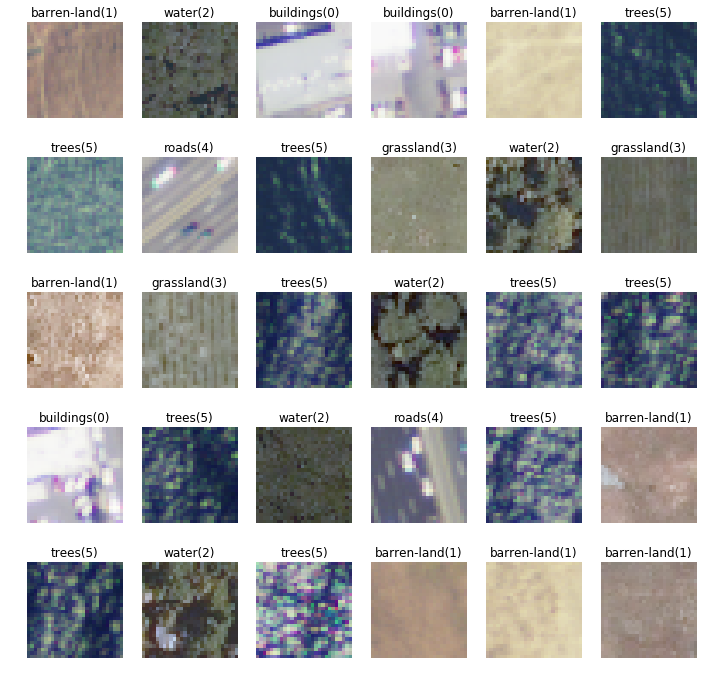

In [5]:
fig, m_axs = plt.subplots(5, images.shape[0]//5, figsize = (12, 12))
# Vector que guarda una imagen de cada clase
img_vector = []
label_vector = []
i = 0
for (x, y, c_ax) in zip(images, labels, m_axs.flatten()):
    c_ax.imshow(x, interpolation = 'none')
    c_ax.axis('off')
    # c_ax.set_title(('Cat {}: '+ CLASSNAMES[str(y)]).format(y) )
    c_ax.set_title(((CLASSNAMES[str(y)])+"({})").format(y))
    if i == y:
        img_vector.append(x)
        label_vector.append(y)
        i+=1
    

#### El raw_img_vector transforma el img_vector de tipo list a un numpay array, esto con el objetivo de poder utilizar su información de manera compatible con los metodos que hemos definido para el procesamiento de datos de nuestra red neuronal

In [6]:
raw_img_vector = np.array(img_vector)
print(raw_img_vector.shape)
print(raw_img_vector[5:6].shape)


(6, 28, 28, 3)
(1, 28, 28, 3)


#### Veamos los ejemplos que tomamos:

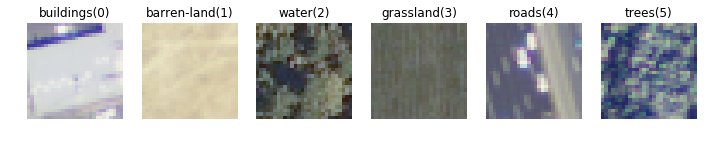

In [7]:
fig, m_axs = plt.subplots(1, 6, figsize = (12, 12))
for (x, y, c_ax) in zip(img_vector, label_vector, m_axs.flatten()):
    c_ax.imshow(x, interpolation = 'none')
    c_ax.axis('off')
    c_ax.set_title(('Cat {}: '+ CLASSNAMES[str(y)]).format(y) )
    c_ax.set_title(((CLASSNAMES[str(y)])+"({})").format(y))

### Definimos métodos utiles y la arquitectura de la red

In [8]:
n_classes = 6
shape = 28
n_channels = 3
epochs = 2
extract1 = 0
extract2 = 0

# defining useful methods
def count_csv_rows(csvfile):
    total_rows = 0
    with open(csvfile, 'rt') as file:
        row_count = sum(1 for row in csv.reader(file))
        total_rows = row_count
    file.close()    
    return total_rows

def count_files(dir_path):
    total_files = 0
    for file in os.listdir(dir_path):
        #avoid invisible files to be counted
        if not file.startswith('.'):
            total_files += 1

    return total_files

def shuffle_files(file1, file2):
    filenames = list(zip(file1, file2))
    random.shuffle(filenames)
    file1, file2 = zip(*filenames)
    return file1, file2

def process_data(img_df, labels_df, img_shape):
    # Pre-processing data. Returns numpy arrays
    np_x = img_df.values.astype(np.uint8)
    np_x = np_x.reshape(-1, img_shape, img_shape, 4)
    np_x = np_x[:, :, :, :3]

    np_y = labels_df.values.astype(np.uint8)

    return np_x, np_y

def getActivations(layer,img, name):
    units = sess.run(layer,feed_dict={x: img, keep_prob:1.0})
    plotNNFilter(units, name)

def plotNNFilter(units, name):
    filters = units.shape[3]
    fig = plt.figure(1, figsize=(15,15))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        fig.add_subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i])
        plt.tight_layout()
    #fig.savefig(name+'.png')
    return fig


def ConvLayer(input_layer,n_filters,f_shape, name):
    return tf.layers.conv2d(inputs=input_layer, filters=n_filters, kernel_size=f_shape,
        strides=1, padding="same", name=name, activation=tf.nn.relu)

def Pooling(input_layer,name):
    return tf.layers.max_pooling2d(inputs=input_layer, pool_size=2,
        strides=2, padding="same", name=name)

def OutputLayer(dense_layer):
    return tf.layers.dense(inputs=dense_layer, units=n_classes)


#defining model
def my_cnn_arch(input_layer):
    # Defining filters
    n_filters = 32
    f_shape = 3

    # input -> first layer
    conv_layer1 = ConvLayer(input_layer, n_filters, f_shape, 'conv_layer1')
    conv_layer2 = ConvLayer(conv_layer1, n_filters, f_shape, 'conv_layer2')
    pool_layer1 = Pooling(conv_layer2, 'pool_layer1')

    # first layer output -> second layer
    conv_layer3 = ConvLayer(pool_layer1, 2*n_filters, f_shape, 'conv_layer3')
    conv_layer4 = ConvLayer(conv_layer3, 2*n_filters, f_shape, 'conv_layer4')
    pool_layer2 = Pooling(conv_layer4, 'pool_layer2')

    flat_layer = tf.layers.flatten(inputs=pool_layer2)

    dense_layer1 = tf.layers.dense(inputs=flat_layer, units=1024, activation= tf.nn.relu)
    
    dropout = tf.layers.dropout(inputs= dense_layer1, rate=0.4)

    output = OutputLayer(dropout)

    return output

Hemos definidos las constantes extract1 y extract2, que disminuyen la cantidad de archivos de images y labels, respectivamente, para hacer una menor cantidad de computaciones (a costa de precisión)

In [9]:
# paths for training images and labels, testing images and labels
train_images_dir = '/Users/mac/code/custom-cnn/train_images/'
train_labels_dir = '/Users/mac/code/custom-cnn/train_labels/'
test_images_dir  = '/Users/mac/code/custom-cnn/test_images/'
test_labels_dir = '/Users/mac/code/custom-cnn/test_labels/'

# counting files in those directories (easier to count respective labels)
n_training_labels = count_files(train_labels_dir)
n_testing_labels = count_files(test_labels_dir)
n_training_files = n_training_labels
n_testing_files = n_testing_labels

# Lists of all img files and labels
training_filenames = [(train_images_dir+'X_train_%d.csv' % i) for i in range(1,n_training_files-extract1)]
training_labels = [(train_labels_dir+'train_labels_%d.csv' % i) for i in range(1,n_training_labels-extract1)]

testing_filenames = [(test_images_dir+'X_test_%d.csv' % i) for i in range(1,n_testing_files-extract2)]
testing_labels = [(test_labels_dir+'test_labels_%d.csv' % i) for i in range(1,n_testing_labels-extract2)]
print('n training files: ',n_training_files)
print('n training labels: ',n_training_labels)
print('n testin files: ',n_testing_files)
print('n testin labels: ',n_testing_labels)
# Shuffling files
training_filenames, training_labels = shuffle_files(training_filenames, training_labels)
testing_filenames, testing_labels = shuffle_files(testing_filenames, testing_labels)


# Just one file with its respective label for a quick review 
train_file_path = train_images_dir+'X_train_1.csv'
train_label_path = train_labels_dir+'train_labels_1.csv'

# and a testing case
test_file_path = test_images_dir+'X_test_1.csv'
test_label_path =test_labels_dir+'test_labels_1.csv'

# Counting examples per file 
n_rows_train_file = count_csv_rows(train_label_path)
n_rows_test_file = count_csv_rows(test_label_path)

# Hyperparameters and constants regarding each dataset
learning_rate = 0.001 
batch_size = n_rows_train_file//100
test_batch_size = n_rows_test_file//100

# Defining data placeholders
x = tf.placeholder(tf.float32, [None, 28, 28, 3])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder("float")

# Conv Net and Optimization
# prediction = my_cnn_arch(x)

n_filters = 32
f_shape = 3

# input -> first layer
conv_layer1 = ConvLayer(x, n_filters, f_shape, 'conv_layer1')
#conv_layer2 = ConvLayer(conv_layer1, n_filters, f_shape, 'conv_layer2')
pool_layer1 = Pooling(conv_layer1, 'pool_layer1')

# first layer output -> second layer
#conv_layer3 = ConvLayer(pool_layer1, 2*n_filters, f_shape, 'conv_layer3')
#conv_layer4 = ConvLayer(conv_layer3, 2*n_filters, f_shape, 'conv_layer4')
#pool_layer2 = Pooling(conv_layer4, 'pool_layer2')

flat_layer = tf.layers.flatten(inputs=pool_layer1)

dense_layer1 = tf.layers.dense(inputs=flat_layer, units=1024, activation= tf.nn.relu)

dropout = tf.layers.dropout(inputs= dense_layer1, rate=keep_prob)

prediction = OutputLayer(dropout)


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))




n training files:  10
n training labels:  10
n testin files:  3
n testin labels:  3


Starting Training...
Training File 0: 
Batch 10: Loss= 184.782410, Training Accuracy= 0.69753
Processing next 10 training Batches...
Batch 20: Loss= 37.737644, Training Accuracy= 0.50000
Processing next 10 training Batches...
Batch 30: Loss= 10.035773, Training Accuracy= 0.74383
Processing next 10 training Batches...
Batch 40: Loss= 2.487093, Training Accuracy= 0.82099
Processing next 10 training Batches...
Batch 50: Loss= 0.940205, Training Accuracy= 0.81790
Processing next 10 training Batches...
Batch 60: Loss= 0.675332, Training Accuracy= 0.87654
Processing next 10 training Batches...
Batch 70: Loss= 0.468479, Training Accuracy= 0.87037
Processing next 10 training Batches...
Batch 80: Loss= 0.361893, Training Accuracy= 0.88580
Processing next 10 training Batches...
Batch 90: Loss= 0.296727, Training Accuracy= 0.89506
Processing next 10 training Batches...
Batch 100: Loss= 0.328738, Training Accuracy= 0.90741
Processing next 10 training Batches...
Training File 1: 
Batch 10: Loss= 0.

Batch 80: Loss= 0.106513, Training Accuracy= 0.95370
Processing next 10 training Batches...
Batch 90: Loss= 0.086487, Training Accuracy= 0.97222
Processing next 10 training Batches...
Batch 100: Loss= 0.136406, Training Accuracy= 0.93519
Processing next 10 training Batches...
Epoch 0: Loss= 0.136406, Training Accuracy= 0.93519
Processing next epoch...
Training File 0: 
Batch 10: Loss= 0.141555, Training Accuracy= 0.94136
Processing next 10 training Batches...
Batch 20: Loss= 0.129891, Training Accuracy= 0.94753
Processing next 10 training Batches...
Batch 30: Loss= 0.141452, Training Accuracy= 0.94444
Processing next 10 training Batches...
Batch 40: Loss= 0.144455, Training Accuracy= 0.93210
Processing next 10 training Batches...
Batch 50: Loss= 0.132892, Training Accuracy= 0.95370
Processing next 10 training Batches...
Batch 60: Loss= 0.113730, Training Accuracy= 0.94444
Processing next 10 training Batches...
Batch 70: Loss= 0.155690, Training Accuracy= 0.93519
Processing next 10 trai

Batch 50: Loss= 0.124923, Training Accuracy= 0.95062
Processing next 10 training Batches...
Batch 60: Loss= 0.170891, Training Accuracy= 0.93210
Processing next 10 training Batches...
Batch 70: Loss= 0.087241, Training Accuracy= 0.96605
Processing next 10 training Batches...
Batch 80: Loss= 0.076228, Training Accuracy= 0.97840
Processing next 10 training Batches...
Batch 90: Loss= 0.075214, Training Accuracy= 0.96914
Processing next 10 training Batches...
Batch 100: Loss= 0.076704, Training Accuracy= 0.96914
Processing next 10 training Batches...
Epoch 1: Loss= 0.076704, Training Accuracy= 0.96914
Processing next epoch...
Training has finished.
Starting Testing...
Testing File {:.2f}:  0
Testing File {:.2f}:  1
Testing Accuracy: 0.95504


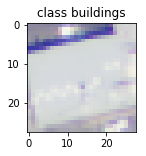

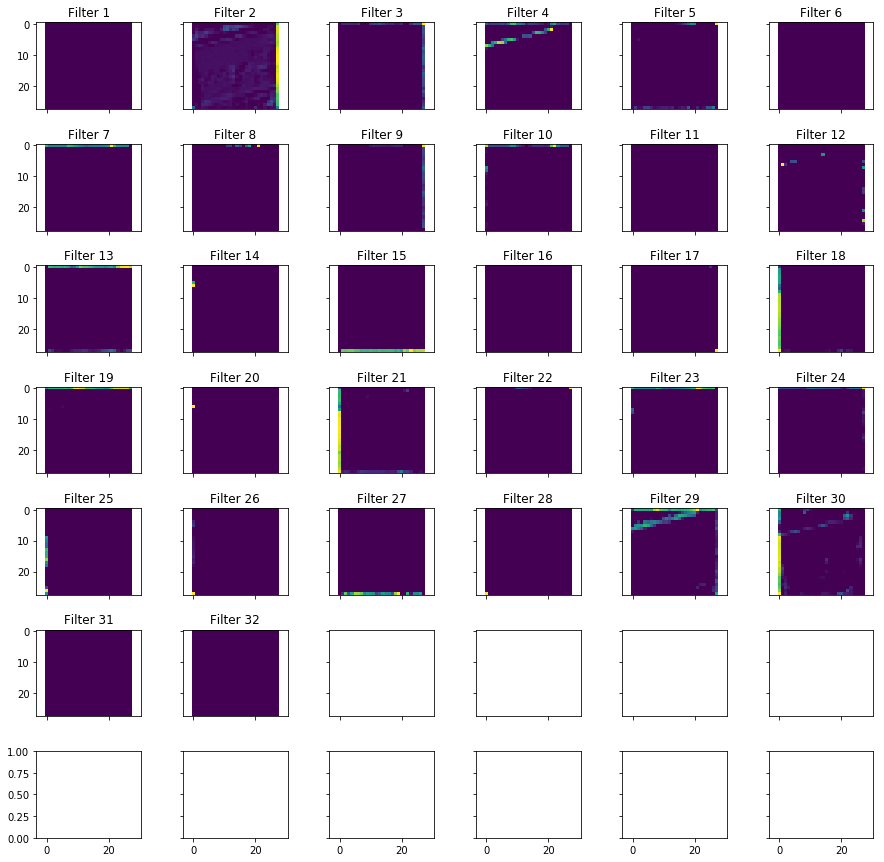

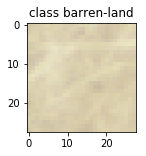

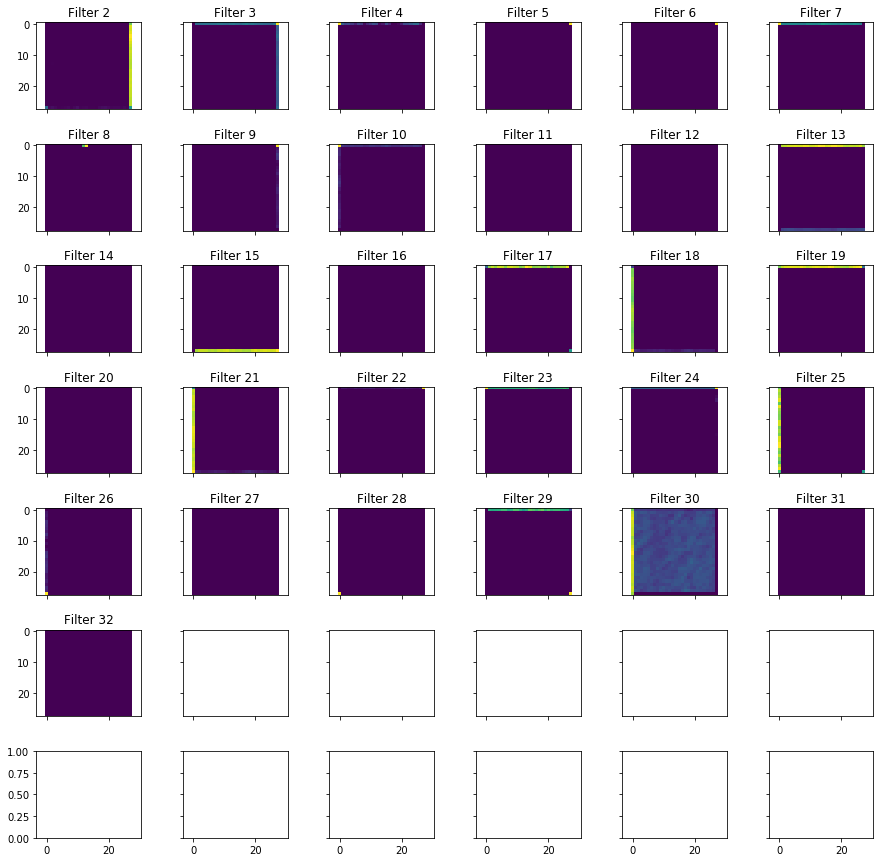

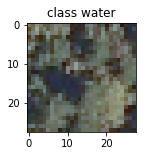

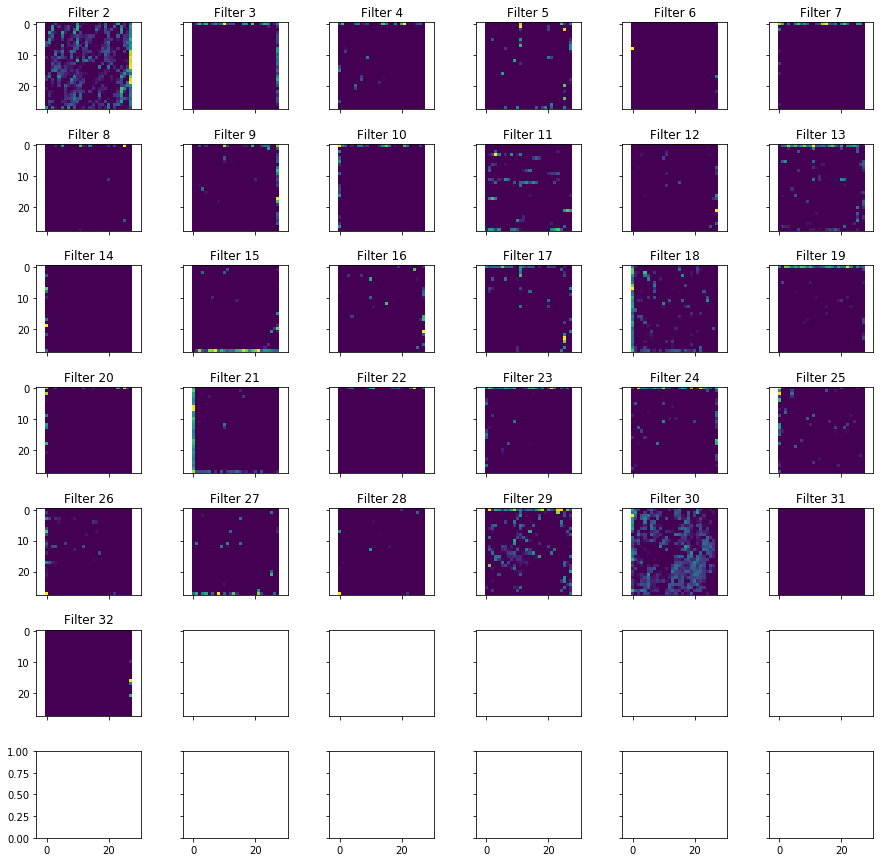

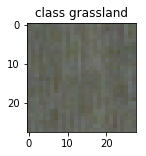

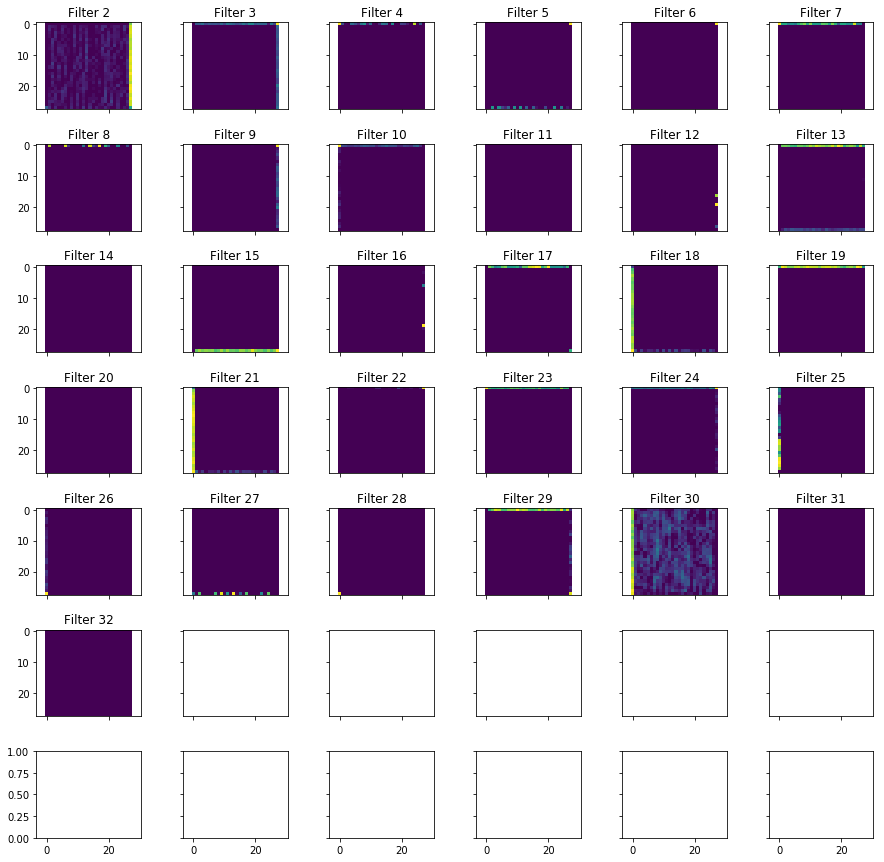

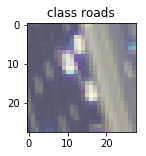

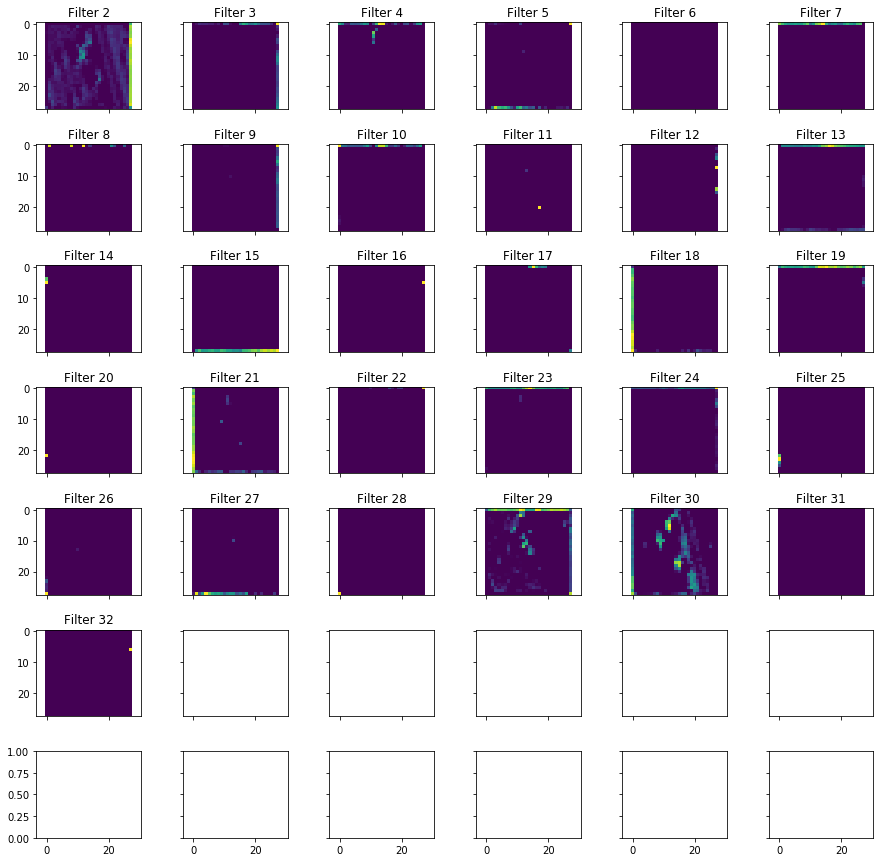

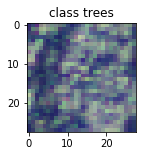

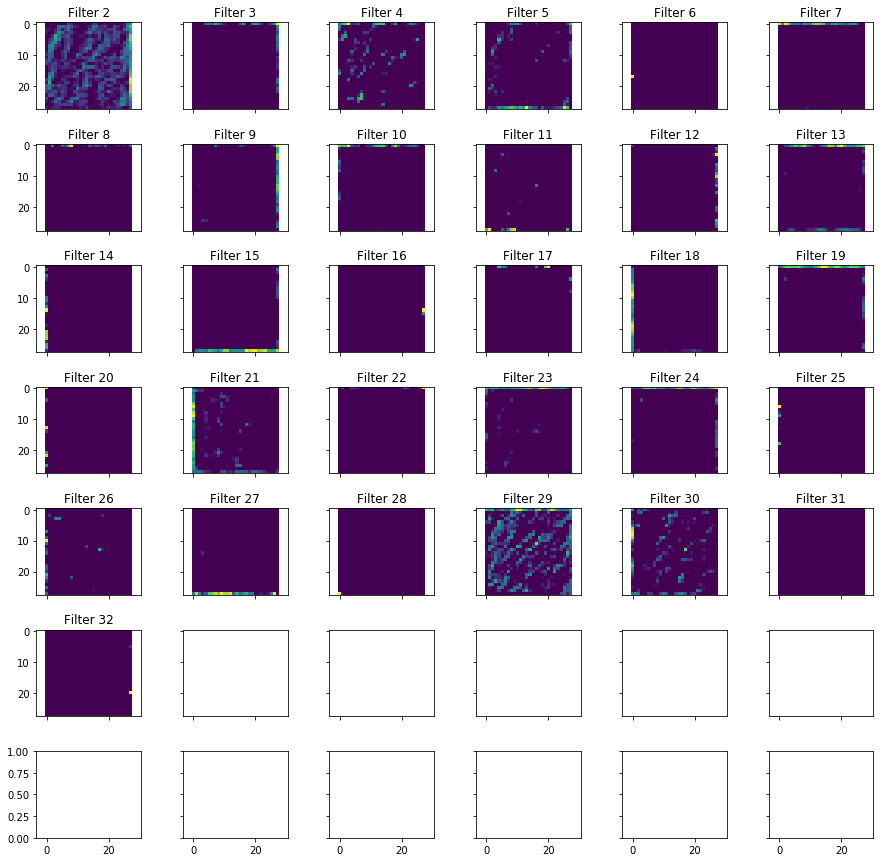

In [10]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    train_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    print("Starting Training...")
    for i in range(epochs):

        for j in range(len(training_filenames)):
            print("Training File " + str(j) + ": ")
            cnt = 1
            for image_chunk,label_chunk in zip(pd.read_csv(training_filenames[j], header=None, chunksize= batch_size), pd.read_csv(training_labels[j],header=None,chunksize=batch_size)):
                batch_x, batch_y = process_data(image_chunk, label_chunk, shape)

                # Run optimization op (backprop).
                opt = sess.run(optimizer, feed_dict={x: batch_x,y: batch_y, keep_prob: 0.5})
                loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

                if(cnt%10==0):
                    train_loss.append(loss)
                    train_accuracy.append(acc)
                    print("Batch " + "{:2d}".format(cnt)  + ": Loss= " + \
                                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                                  "{:.5f}".format(acc))
                    print("Processing next 10 training Batches...")
                cnt+=1

        print("Epoch " + str(i) + ": Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Processing next epoch...")

    print("Training has finished.")


    print("Starting Testing...")

    total_test_acc = 0
    total_test_batches = 1
    for k in range(len(testing_filenames)):
        print('Testing File {:.2f}: ', k)
        cnt = 1
    # TODO: shuffle those dataframes    
        for image_chunk,label_chunk in zip(pd.read_csv(test_file_path, header=None, chunksize= test_batch_size), pd.read_csv(test_label_path,header=None,chunksize=test_batch_size)):
            test_batch_x, test_batch_y = process_data(image_chunk, label_chunk, shape)

            test_acc, test_loss = sess.run([accuracy,cost], feed_dict={x: test_batch_x, y : test_batch_y, keep_prob: 1.0})
            total_test_acc += test_acc
   #         print("Batch "+ "{:2d}".format(cnt) + ": Loss= " + \
   #                       "{:.6f}".format(test_loss) + ", Testing Accuracy= " + \
   #                       "{:.5f}".format(test_acc))
   #         print("Processing next testing Batch...")
            cnt+=1
            total_test_batches += 1
    
    avg_test_acc = total_test_acc/total_test_batches
    print("Testing Accuracy:","{:.5f}".format(avg_test_acc))
    
    
    k = 0
    n = 0
    for k in range(len(img_vector)):
        y = label_vector[k]
        # ploteamos la imagen que pasa por el layer (i.e una imagen de cada categoria)
        main = plt.figure(figsize=(2,2))
        plt.title('class ' + CLASSNAMES[str(y)])
        plt.savefig(CLASSNAMES[str(y)])
        plt.imshow(img_vector[k])

        raw_x = raw_img_vector[k:k+1]
        units = sess.run(conv_layer1,feed_dict={x: raw_x, keep_prob:1.0})
        filters = units.shape[3]

        n_columns = 6
        n_rows = math.ceil(filters / n_columns) + 1
        

        # armamos  una grilla para mostrar la activacion de los distintos filtros
        fig, ax = plt.subplots(n_rows, n_columns, sharex='col', sharey='row', figsize=(15,15))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        for i in range(n_rows):
            for j in range(n_columns):
                if n <filters:
                    ax[i, j].imshow(units[0,:,:,n])
                    ax[i, j].set_title('Filter ' + str(n+1))
                n+=1
        name_of_figure = CLASSNAMES[str(y)]+'-'+str(filters)+'-filters.png'
        n = 1
        plt.savefig(name_of_figure)
        
        
        
        
        
        

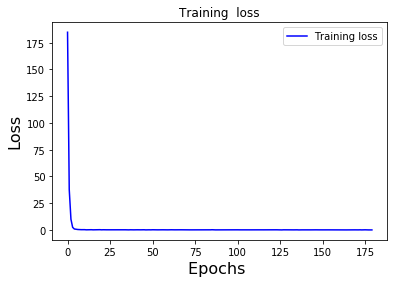

In [11]:
    fig1 = plt.figure()
    plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
    plt.title('Training  loss')
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.legend()
    fig1.savefig('training-loss.png')
    plt.show()

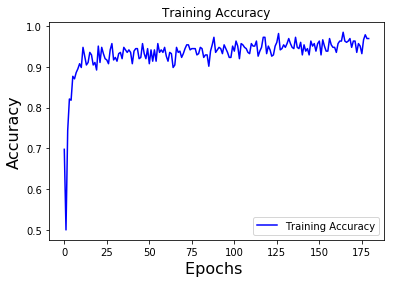

In [12]:
    fig2 = plt.figure()
    plt.plot(range(len(train_accuracy)), train_accuracy, 'b', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.legend()
    fig2.savefig('training-acc.png')
    plt.show()